### PANOPTES State Machine

This notebook gives an example run through of the PANOPTES State Machine (PSM). Below we manually walk through the various states so we can explain what happens along the way. When PANOPTES is actually running these steps will automatically transition.

In [1]:
# Load the PANOPTES module dir
from IPython.display import Image
import sys
sys.path.append('../../')

from panoptes.core import Panoptes

#### Create

The first step is to create an instance of our `Panoptes` class. Here we instantiate a simulator version. Possible values for the simulator include: `all`, `weather`, `mount`, `camera`

In [2]:
pan = Panoptes(simulator=['all'])

20:36:01 UTC - ********************************************************************************
20:36:01 UTC - Initializing PANOPTES unit
20:36:01 UTC - Welcome PAN001!
20:36:01 UTC - Loading state table
20:36:01 UTC - 	 messaging system
20:36:01 UTC - 	 weather station
20:36:01 UTC - 	 observatory
20:36:01 UTC - 	Initializing observatory
20:36:01 UTC - 		 Setting up location
20:36:01 UTC - 		 Setting up mount
20:36:01 UTC - 		Using simulator mount
20:36:01 UTC - 		 Setting up cameras
20:36:01 UTC - 		 Using simulator camera
20:36:01 UTC - 		 Using simulator camera
20:36:01 UTC - 		 Setting up scheduler
20:36:01 UTC - 	 Observatory initialized
20:36:01 UTC - PAN001 says: Hi! I'm all set to go!


Above you see the log output from the unit. Here `PAN001` is the name of the unit. The messages that start with `PAN001 says:` are intended to be user-friendly messages. Full debug log output is written to `/var/panoptes/log/panoptes.log`.

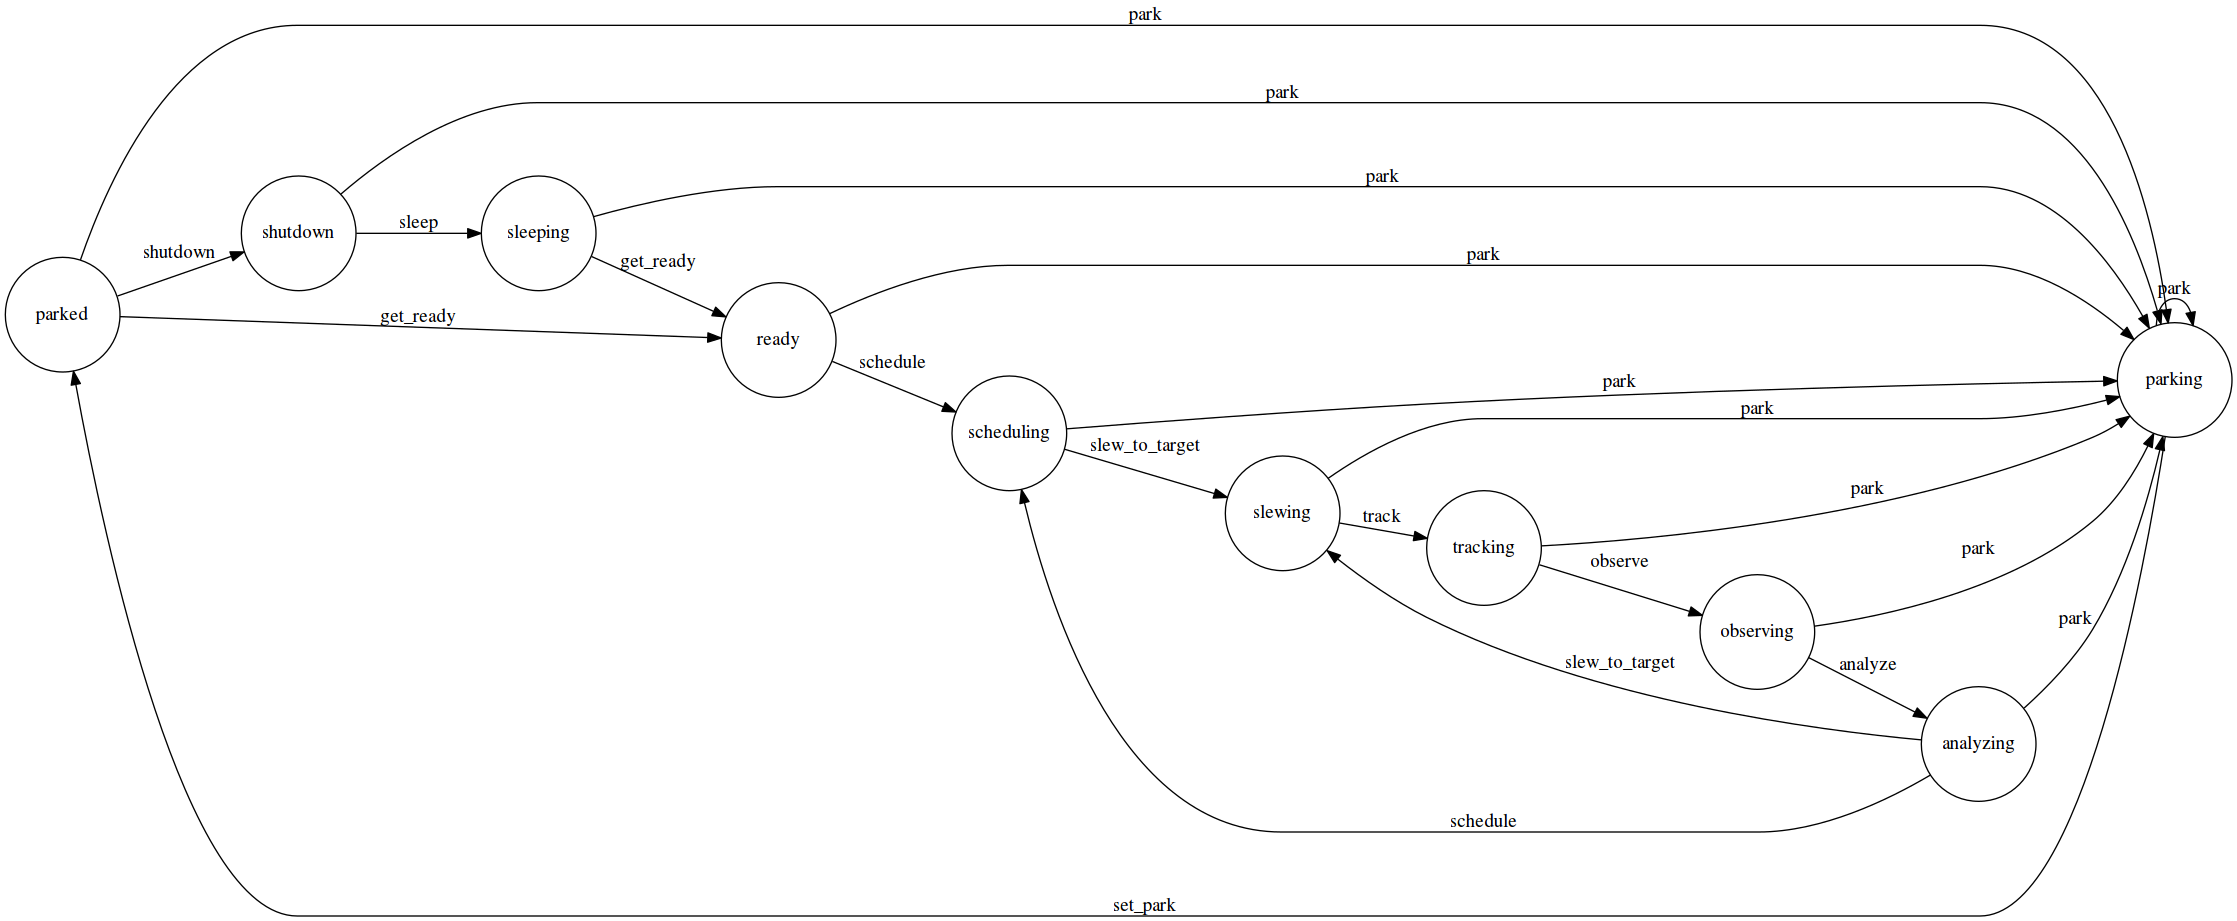

In [3]:
pan.get_graph().draw('state.png', prog='dot')
Image('state.png')

#### Get Ready!

Our unit is now up and running, sitting in the default state of `parked`. The first thing we want to do is get our unit in the `ready` __state__. To do this, we call `get_ready()`, which is the __transition__.

In [4]:
# Call the transition to go from parked->ready
pan.get_ready()

20:36:02 UTC - PAN001 says: Getting ready! Woohoo!
20:36:02 UTC - PAN001 says: Up and ready to go!


True

We can double check which state we are currently in with:

In [5]:
pan.state

'ready'

#### Schedule

Our unit is now initialized and ready to start processing for the night. The first thing to do is send the unit to the `scheduling` state via the `schedule()` transition:

In [6]:
pan.schedule()

20:36:02 UTC - PAN001 says: Ok, I'm finding something good to look at...
20:36:02 UTC - Evaluating candidate targets
20:36:03 UTC - Chosen target is M 2 with priority 110
20:36:03 UTC - PAN001 says: Got it! I'm going to check out: M 2


True

The output above indicates that we successfully found a target to look at. Let's double-check that we are now in the `scheduling` state still and then let's transition to `slewing` via the transition `slew_to_target()`:

In [7]:
print(pan.state)
pan.slew_to_target()

scheduling
20:36:03 UTC - PAN001 says: I'm slewing over to the coordinates to track the target.


True

Now we want to start tracking the target so we transition to the `tracking` state:

In [8]:
pan.track()

False

But we notice that we got a `False` return value, meaning the transition didn't occur. This is because if we look at the transition event we can see it has some conditions associated with it:

In [9]:
for condition in pan.events['track'].transitions['slewing'][0].conditions:
    print(condition.func)

check_safety
mount_is_tracking


Namely, we want to see if the `mount_is_tracking`, which it is not. Normally the event loop for the state machine will handle these automatic transitions, so here we manually set the mount to tracking:

___Note___: Never do this for real

In [10]:
pan.observatory.mount._is_tracking = True
pan.track()

20:36:03 UTC - PAN001 says: I'm now tracking the target.


True

In [11]:
pan.state

'tracking'

In [12]:
pan.observe()

20:36:03 UTC - PAN001 says: I'm finding exoplanets!


True

In [13]:
pan.analyze()

20:36:04 UTC - PAN001 says: Analyzing image...


True

In [14]:
pan.park()

20:36:04 UTC - PAN001 says: I'm takin' it on home and then parking.
20:36:04 UTC - Going home then parking


True

In [15]:
pan.set_park()

20:36:04 UTC - PAN001 says: I'm parked now. Phew.


True

In [16]:
pan.shutdown()

20:36:04 UTC - PAN001 says: I'm in Shut Down.


True

In [17]:
pan.sleep()

20:36:04 UTC - PAN001 says: ZZzzzz...


True